Importing Modules

In [18]:
import os
import cv2
import copy
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm

import SimpleITK as stk
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from skimage import measure

Paths for Source & Destination of Data

In [19]:
root = "F:/Downloads/Lung_Cancer_Detection-main/Lung_Cancer_Detection-main/DATA/"
target_root = "../ProcessedData/"

Reading Subsets of Training Data & annotations.csv

In [20]:
subset = 9    # Ran for 0...9
file_list = glob("F:/Downloads/Lung_Cancer_Detection-main/Lung_Cancer_Detection-main/DATA/subset9/*.mhd")
annotations_df = pd.read_csv(root+"annotations.csv")
print("Files Count:",len(file_list))
print("DF Count:",len(annotations_df))
annotations_df.head()

Files Count: 88
DF Count: 1186


,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150


Distribution of nodules size (diameter)

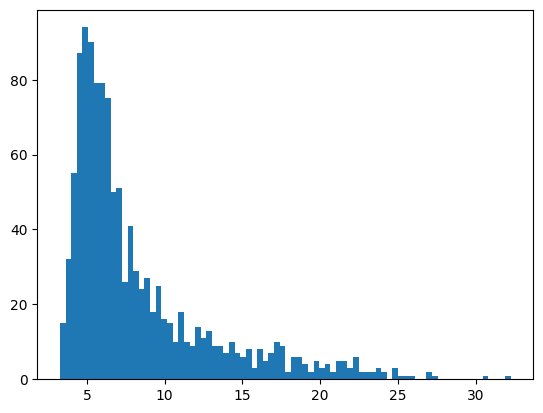

In [21]:
d = annotations_df['diameter_mm'].values
fig = plt.hist(d, bins=80)

Function to filter ctscan files that are in subset as well as in annotations.csv

In [22]:
def get_filename(file_list, file):
    for f in file_list:
        if file in f:
            return f

In [23]:
annotations_df["filename"] = annotations_df["seriesuid"].map(lambda file: get_filename(file_list, file))
annotations_df = annotations_df.dropna()
annotations_df = annotations_df[annotations_df['diameter_mm']>=3.9]     # Excluding nodules with diameter less than 3.9mm
print(len(annotations_df))

100


In [24]:
annotations_df.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm,filename
8,1.3.6.1.4.1.14519.5.2.1.6279.6001.102681962408...,105.055792,19.825260,-91.247251,21.089619,F:/Downloads/Lung_Cancer_Detection-main/Lung_C...
36,1.3.6.1.4.1.14519.5.2.1.6279.6001.112767175295...,-65.870136,50.730440,-90.803304,5.915845,F:/Downloads/Lung_Cancer_Detection-main/Lung_C...
37,1.3.6.1.4.1.14519.5.2.1.6279.6001.112767175295...,-105.917119,-17.656588,-105.091752,5.484679,F:/Downloads/Lung_Cancer_Detection-main/Lung_C...
38,1.3.6.1.4.1.14519.5.2.1.6279.6001.112767175295...,42.296133,56.151735,-84.661662,6.477966,F:/Downloads/Lung_Cancer_Detection-main/Lung_C...
39,1.3.6.1.4.1.14519.5.2.1.6279.6001.112767175295...,-137.500567,-21.653604,-152.036638,4.362886,F:/Downloads/Lung_Cancer_Detection-main/Lung_C...


Function to load mhd files

In [25]:
def load_mhd(file):
    mhdimage = stk.ReadImage(file)
    ct_scan = stk.GetArrayFromImage(mhdimage)
    origin = np.array(list(mhdimage.GetOrigin()))
    space = np.array(list(mhdimage.GetSpacing()))
    return ct_scan, origin, space

In [26]:
def make_mask(img, center, diam):
    mask = np.zeros_like(img, dtype=np.uint8)
    mask = cv2.circle(mask, (abs(int(center[0])),abs(int(center[1]))),int(abs(diam//2)), 255, -1)
    return mask

In [27]:
n_neighbour = 4      # Number of neighbour slides to consider

In [28]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))  # CLAHE(Contrast Limited Adaptive Histogram Equalization) filter for enhancing the contrast of an image

# Iterating over all the files in the subset
for i,file in tqdm(enumerate(np.unique(annotations_df['filename'].values))):
    annotations = annotations_df[annotations_df["filename"]==file]
    ct, origin, space = load_mhd(file)      # Loading the CT scan
    num_z, height, width = ct.shape
    ct_norm = cv2.normalize(ct, None, 0, 255, cv2.NORM_MINMAX)   # Normalizing the CT scan
    for idx, row in annotations.iterrows():
        node_x = int(row["coordX"])     # X coordinate of the nodule
        node_y = int(row["coordY"])     # Y coordinate of the nodule
        node_z = int(row["coordZ"])     # Z coordinate of the nodule
        diam = int(row["diameter_mm"])  # Diameter of the nodule

        center = np.array([node_x, node_y, node_z])   # nodule center (x,y,z)
        v_center = np.rint((center-origin)/space)   # nodule center in voxel space (still x,y,z ordering)
        v_diam = int(diam/space[0])+5       # Diameter of the nodule in voxel space

        img_norm_neighbours = []
        img_norm_improved_neighbours = []
        mask_neighbours = []
        img_norm = None
        img_norm_improved = None
        mask = None
        
        if 18<v_diam<22:              # If nodule diameter is of medium size the take two neighbour slides into consideration
            n_neighbour = 2
        
        min_i = max(0,(int(v_center[2])-n_neighbour))
        max_i = min((int(v_center[2])+n_neighbour),(num_z-1))
        n = max_i-min_i
        
        img_norm = ct_norm[int(v_center[2]),:,:]    # a slice of the CT scan containing the nodule
        img_norm = cv2.resize(img_norm, (512,512))  # Resizing the CT scan to 512x512
        img_norm_improved = clahe.apply(img_norm.astype(np.uint8))  # Applying CLAHE filter to the image
        mask = make_mask(img_norm, v_center, v_diam)    # Creating a mask of the nodule
        
        if v_diam>18:      # If the nodule is too big, we will also take neighboring slices
            for i in range(min_i, max_i+1):
                if i==int(v_center[2]):
                    continue
                
                im_n = ct_norm[i,:,:]
                im_n = cv2.resize(im_n, (512,512))
                im_n_improved = clahe.apply(im_n.astype(np.uint8))
                dia = int(2*abs(v_center[2]-i))    # Decrease mask diameter because nodule diameter decrease as we move away from its center
                msk = make_mask(im_n, v_center, v_diam-dia)
                img_norm_neighbours.append(im_n)
                img_norm_improved_neighbours.append(im_n_improved)
                mask_neighbours.append(msk)
            assert len(img_norm_neighbours)==len(img_norm_improved_neighbours)==len(mask_neighbours)==n  
            
        # Calculating the threshold value for extracting the nodule mask using binary thresholding
        mask = cv2.bitwise_and(img_norm, img_norm, mask=cv2.dilate(mask,kernel=np.ones((5,5))))
        pts = mask[mask>0]
        kmeans2 = KMeans(n_clusters=2).fit(np.reshape(pts,(len(pts),1)))
        centroids2 = sorted(kmeans2.cluster_centers_.flatten())
        threshold2 = np.mean(centroids2)
        
        _, mask = cv2.threshold(mask, threshold2, 255, cv2.THRESH_BINARY)
        
        
        if v_diam>18:
            for i in range(n):
                mask_neighbours[i] = cv2.bitwise_and(img_norm_neighbours[i], img_norm_neighbours[i], mask=cv2.dilate(mask_neighbours[i],kernel=np.ones((5,5))))
                _, mask_neighbours[i] = cv2.threshold(mask_neighbours[i], threshold2, 255, cv2.THRESH_BINARY)
        
        
        # Calculating the threshold value to segment the lungs from CT scan slices using binary thresholding
        centeral_area = img_norm[100:400, 100:400]
        kmeans = KMeans(n_clusters=2).fit(np.reshape(centeral_area, [np.prod(centeral_area.shape), 1]))
        centroids = sorted(kmeans.cluster_centers_.flatten())
        threshold = np.mean(centroids)
        
        # Steps to segment the lungs from CT scan slices
        ret, lung_roi = cv2.threshold(img_norm, threshold, 255, cv2.THRESH_BINARY_INV)
        lung_roi = cv2.erode(lung_roi, kernel=np.ones([4,4]))
        lung_roi = cv2.dilate(lung_roi, kernel=np.ones([13,13]))
        lung_roi = cv2.erode(lung_roi, kernel=np.ones([8,8]))

        labels = measure.label(lung_roi)        # Labelling different regions in the image
        regions = measure.regionprops(labels)   # Extracting the properties of the regions
        good_labels = []
        for prop in regions:        # Filtering the regions that are not too close to the edges
            B = prop.bbox           # Regions that are too close to the edges are outside regions of lungs
            if B[2]-B[0] < 475 and B[3]-B[1] < 475 and B[0] > 40 and B[2] < 472:
                good_labels.append(prop.label)
        lung_roi_mask = np.zeros_like(labels)
        for N in good_labels:
            lung_roi_mask = lung_roi_mask + np.where(labels == N, 1, 0)

        # Steps to get proper segmentation of the lungs without noise and holes
        contours, hirearchy = cv2.findContours(lung_roi_mask,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
        external_contours = np.zeros(lung_roi_mask.shape)
        for i in range(len(contours)):
            if hirearchy[0][i][3] == -1:  #External Contours
                area = cv2.contourArea(contours[i])
                if area>518.0:
                    cv2.drawContours(external_contours,contours,i,(1,1,1),-1)
        external_contours = cv2.dilate(external_contours, kernel=np.ones([4,4]))
        
        external_contours = cv2.bitwise_not(external_contours.astype(np.uint8))
        external_contours = cv2.erode(external_contours, kernel=np.ones((7,7)))
        external_contours = cv2.bitwise_not(external_contours)
        external_contours = cv2.dilate(external_contours, kernel=np.ones((12,12)))
        external_contours = cv2.erode(external_contours, kernel=np.ones((12,12)))
        
        img_norm_improved = img_norm_improved.astype(np.uint8)
        external_contours = external_contours.astype(np.uint8)      # Final segmentated lungs mask
        extracted_lungs = cv2.bitwise_and(img_norm_improved, img_norm_improved, mask=external_contours)
        
        mask = mask.astype(np.uint8)
        # np.save(r"F:\Downloads\Lung_Cancer_Detection-main\Lung_Cancer_Detection-main\DATA\ProcessedData\nodule_mask\masks_09.npy",mask)
        np.save(os.path.join("F:/Downloads/Lung_Cancer_Detection-main/Lung_Cancer_Detection-main/DATA/ProcessedData/nodule_mask/", f"masks_{subset}_{i}_{idx}_{i}.npy"), mask)
        np.save(os.path.join("F:/Downloads/Lung_Cancer_Detection-main/Lung_Cancer_Detection-main/DATA/ProcessedData/lungs_roi/", f"lungs_{subset}_{i}_{idx}_{i}.npy"), extracted_lungs)
        # np.save(r"F:\Downloads\Lung_Cancer_Detection-main\Lung_Cancer_Detection-main\DATA\ProcessedData\lungs_roi\lungs_roi.npy", extracted_lungs)
        
        extracted_lungs_neighbours = [None]*n
        
        if v_diam>18:
            for i in range(n):
                img_norm_improved_neighbours[i] = img_norm_improved_neighbours[i].astype(np.uint8)
                extracted_lungs_neighbours[i] = cv2.bitwise_and(img_norm_improved_neighbours[i], img_norm_improved_neighbours[i], mask=external_contours)
                mask_neighbours[i] = mask_neighbours[i].astype(np.uint8)
                np.save(os.path.join("F:/Downloads/Lung_Cancer_Detection-main/Lung_Cancer_Detection-main/DATA/ProcessedData/nodule_mask/", f"masks_{subset}_{i}_{idx}_{i}.npy"), mask_neighbours[i])
                np.save(os.path.join("F:/Downloads/Lung_Cancer_Detection-main/Lung_Cancer_Detection-main/DATA/ProcessedData/lungs_roi/", f"lungs_{subset}_{i}_{idx}_{i}.npy"), extracted_lungs_neighbours[i])

57it [00:16,  3.41it/s]
